In [1]:
%matplotlib inline

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

# Study on the Football Statistics and the Correctness of the Odds
### by Kalin Primov

## Abstract
.......

## Introduction
The goal of this study is to analyze the goals in the football games and see how are they scored, also will try to connect the results from the games with the odds and will try to find better way of predicting the final result. The data with the odds is taken from *oddsportal* and the data with the games is taken from various sources. Also would be measured the accuracy of odds such as both teams to score, more or less than 2.5 goals and both team to or not to score. The data is for the five major leagues - La Liga, Premier League, Bundesliga, Ligue 1 and Seria A and we will see where and how the predictions and reality are different for the leagues.

## Data Manipulation

### Data Collection
The data is divided into 2 datasets in the '''ginf.csv''' is the data from the _odsportal_ with the odds for the games. The columns in the dataset are:
* id_odsp - unique game identifier
* link_odsp - link to oddsportal page
* adv_stats - boolean if the game has detailed event data
* data
* league
* country
* season
* ht - home team
* at - away team
* fthg - full time home goals
* ftag - full time away goals
* odd_h - home win odds
* odd_d - draw odds
* odd_a - away win odds
* odd_over - over 2.5 goals odds
* odd_under - under 2.5 goals odds
* odd_bts - both teams to score odds
* odd_bts_n - both teams not to score odds

In the ```events.csv``` is the data from the events. We will use it to compare it with the data from ```ginf.csv``` and see if there are other factor, which affect games. The columns in the dataset are:

* id_odsp - unique game identifier
* id_event - unique identifier of event (id_odsp + sort_order)
* sort_order - chronological sequence of events in a game
* time - minutes of the game
* text - text commentary
* event_type - primary event. 11 unique events
* event_type2 - secondary event. 4 unique events
* side - 1-Home, 2-Away
* event_team - team that produced the event
* opponent - team that the event happened against
* player - name of the player involved in the main event
* player2 - name of player involved in secondary event
* player_in - substitude in
* player_out - substitude out
* shot_place - 13 possible placements of the shot
* shot_outcome
* is_goal
* location - location on the pitch
* bodypart
* assist_method
* situation
* fast_break

In [3]:
odds_data = pd.read_csv('data/ginf.csv')
events_data = pd.read_csv('data/events.csv')

odds_data = odds_data.drop(['link_odsp','adv_stats','season'], axis=1)
events_data = events_data.drop(['fast_break', 'sort_order', 
                                'assist_method', 'player2', 'text', 
                                'player_in', 'player_out'], axis=1)

In [4]:
odds_data.head()
odds_data.columns = ['id','data','league', 'country','home_team','away_team','home_goals',
                     'away_goals','odd_home','odd_draw','odd_away','odd_over',
                     'odd_under','odd_both_score', 'odd_none_scores']
events_data.columns = ['id_game','id_event', 'time', 'primary_event', 'secondary_event',
                     'side', 'event_team', 'opponent', 'player', 'show_place', 'show_outcome',
                     'is_goal', 'location', 'bodypart', 'situation']

Most of the stats are given index and the index corresponds to the dictionary. In the dictionary is the full meaning if the values in the columns.

In [5]:
encoding = pd.read_csv('data/dictionary.txt', sep='\t', index_col=0, names=('id', 'event_type'), header=None)
primary_event=encoding[1:12]
secondary_event=encoding[14:18]
side=encoding[19:21]
shot_place=encoding[22:35]
shot_outcome=encoding[36:40]
location=encoding[41:60]
bodypart=encoding[61:64]
assist_method=encoding[65:70]
situition=encoding[71:75]

In [6]:
primary_event

,event_type
id,
0,Announcement
1,Attempt
2,Corner
3,Foul
4,Yellow card
5,Second yellow card
6,Red card
7,Substitution
8,Free kick won


In [7]:
secondary_event

,event_type
id,
12,Key Pass
13,Failed through ball
14,Sending off
15,Own goal


In [8]:
side

,event_type
id,
1,Home
2,Away


In [9]:
shot_place

,event_type
id,
1,Bit too high
2,Blocked
3,Bottom left corner
4,Bottom right corner
5,Centre of the goal
6,High and wide
7,Hits the bar
8,Misses to the left
9,Misses to the right


In [10]:
shot_outcome

,event_type
id,
1,On target
2,Off target
3,Blocked
4,Hit the bar


In [11]:
location

,event_type
id,
1,Attacking half
2,Defensive half
3,Centre of the box
4,Left wing
5,Right wing
6,Difficult angle and long range
7,Difficult angle on the left
8,Difficult angle on the right
9,Left side of the box


In [12]:
bodypart

,event_type
id,
1,right foot
2,left foot
3,head


In [13]:
assist_method

,event_type
id,
0,None
1,Pass
2,Cross
3,Headed pass
4,Through ball


In [14]:
situition

,event_type
id,
1,Open play
2,Set piece
3,Corner
4,Free kick


### Data clean-up
For the correct predictions of the odds, we will need data, which has all the odds, so we will have to remove data.

## When Goals are Scored
Lets see when the teams score moast and does this corrensponds to the odds. The logical conclusion shoud be that thez are almost equalz distributed. 

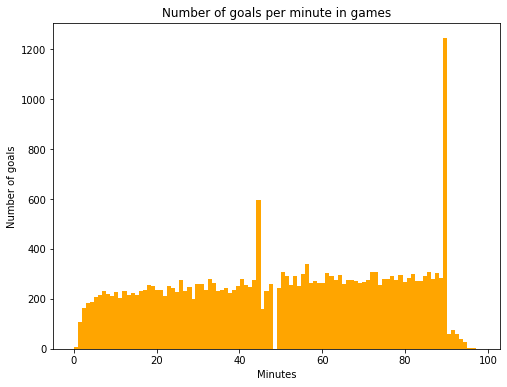

In [15]:
events_data['is_goal'] = events_data['is_goal'].astype('bool')
goals = events_data[events_data['is_goal']]

substitude = events_data[events_data['is_goal']]
fig=plt.figure(figsize=(8,6))
plt.hist(goals.time, width=1, bins=100, color='orange')
plt.xlabel('Minutes')
plt.ylabel('Number of goals')
plt.title('Number of goals per minute in games')
plt.show()

We can easily see spikes in around 45-th and 90-th minute, those are mainly because of the way data is reported in the games. Goals in the extra time are reported in the 45-th and 90-th minute respectively and because of that the spikes exist. Given that, lets see how many more goals are scored in the second half compared to the first half.

In [16]:
goals_first_half = np.size(goals[goals.time <= 45])
goals_second_half = np.size(goals[goals.time <= 90])
print((goals_second_half/goals_first_half))

2.2502792256142965


Out of those goals the distrubution home/away goals are as follow:

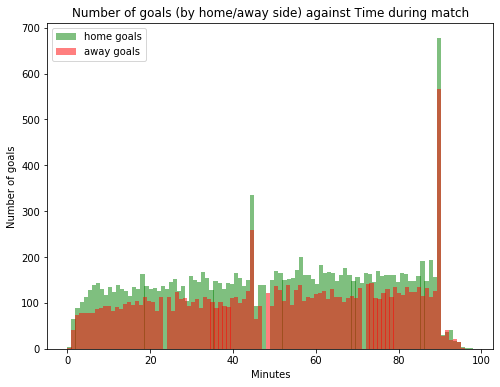

In [17]:
fig=plt.figure(figsize=(8,6))
plt.hist(goals[goals['side']==1]['time'], width=1, bins=100, color='green', label='home goals', alpha=0.5)   
plt.hist(goals[goals['side']==2]['time'], width=1, bins=100, color='red', label='away goals', alpha=0.5) 
plt.xlabel('Minutes')
plt.ylabel('Number of goals')
plt.title('Number of goals (by home/away side) against Time during match')
plt.legend()
plt.show()

For every minute more goals are scored by the home team compared to the away team. This supports the general notion, that the home team has the advantage. On other hand completely dismissed our assumption for near equal goals in the first and second half. In the second half there are far more goals.

### How goals are scored
Interessting statistic will be also how goals are scored

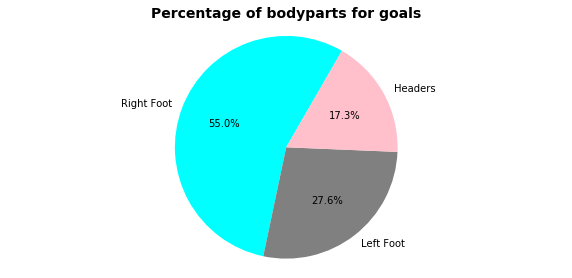

In [18]:
def show_pie_chart_bodyparts(goals_df, title='Percentage of bodyparts for goals'):
    """
    Shows a pie chart as a subplot of the 
    @input goals_df - datafreame with the goals. Muss have the column bodupart
    @input title: default = 'Percentage of bodyparts for goals' - title of the pie chart
    @output - none
    """
    plt.subplot(2,1,1)
    labels=['Right Foot', 'Left Foot', 'Headers']
    sizes=[goals_df[goals_df['bodypart']==1].shape[0], goals_df[goals_df['bodypart']==2].shape[0], goals_df[goals_df['bodypart']==3].shape[0]]
    colors=['cyan', 'grey', 'pink']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=60)
    plt.axis('equal')
    plt.title(title, fontsize=14, fontweight="bold")
    fig=plt.gcf() 
    fig.set_size_inches(10,10)
    plt.show()
show_pie_chart_bodyparts(goals)

The logic is quite clear, as most of the players are right-footed. The percentages look a bit different, when we see how they go in the different leagues:

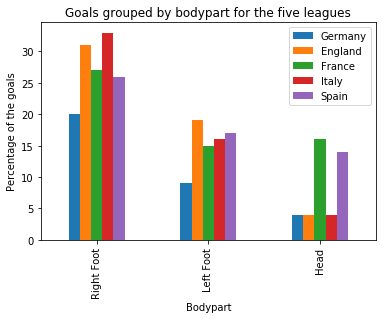

In [19]:
goals = goals.assign(league = odds_data['league'])
grouped_goals = goals.groupby('league')
index = ['Right foot', 'Left foor', 'Head']
ax = grouped_goals.bodypart.value_counts().unstack(0).plot.bar()
ax.legend(['Germany', 'England', 'France', 'Italy', 'Spain'])
plt.xticks(np.arange(3), ('Right Foot', 'Left Foot', 'Head'))
plt.title('Goals grouped by bodypart for the five leagues')
plt.ylabel("Percentage of the goals")
plt.xlabel("Bodypart")
plt.show()


Surprisingly here most goals with head are scored in France and Spain, but in countries, which are famous for more "physical" approach as England and Germany the statistics are very different. Which comfirms the data in the research made by Edward Nsolo, Patric Lambrix and Niklas Carlsson - [Player valuation in European football](https://www.ida.liu.se/~nikca89/papers/mlsa18-football.pdf). 
If we look into the situations, which lead to goal, we migh be able to see more clearly why this result have happened.

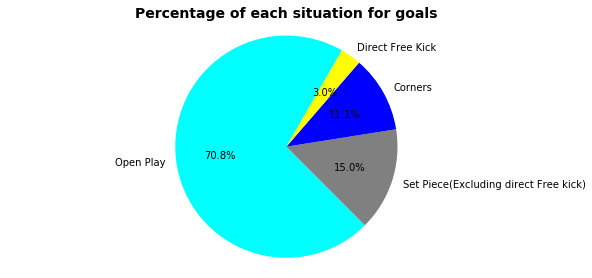

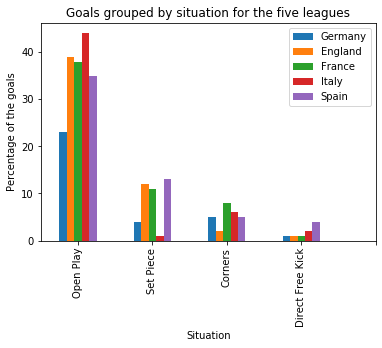

In [20]:
plt.subplot(2,1,1)
labels=["Open Play", "Set Piece(Excluding direct Free kick)","Corners","Direct Free Kick"]
sizes=[goals[goals["situation"]==1].shape[0],goals[goals["situation"]==2].shape[0],goals[goals["situation"]==3].shape[0],goals[goals["situation"]==4].shape[0]]
colors=["cyan","grey","blue","yellow"]
plt.pie(sizes,labels=labels,colors=colors,autopct='%1.1f%%',startangle=60)
plt.axis('equal')
plt.title("Percentage of each situation for goals",fontsize=14,fontweight="bold")
fig=plt.gcf() 
fig.set_size_inches(10,10)

ax = grouped_goals.situation.value_counts().unstack(0).plot.bar()
ax.legend(['Germany', 'England', 'France', 'Italy', 'Spain'])
plt.xticks(np.arange(5), ("Open Play", "Set Piece","Corners","Direct Free Kick"))
plt.title('Goals grouped by situation for the five leagues')
plt.ylabel("Percentage of the goals")
plt.xlabel("Situation")
plt.show()

Again in Spain and France a lot of goals are scored from set pieces and corners, so crossings from open play are not so common and because of that most goals are scored with head. Italy has very little goals scored fro mset pieces and cornners, which confirms the lower amount of goals, scored with the head. From this data laso seems like in Spain are the best direct free kick takers, as there are most of the goals scored from free kicks.

Lets find the best free kick takers and see if this is true.

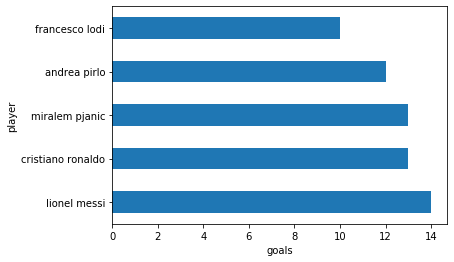

In [21]:
free_kicks=events_data[(events_data["situation"]==4)]
scored_free_kicks = free_kicks[free_kicks['is_goal']]
top_five_players = scored_free_kicks.groupby('player')['player'].count().nlargest(5)
plt.xlabel('goals')
top_five_players.plot.barh()
plt.show()

The dominations in the free kicks is also visible and in the player's statistics top two players are from Spain and the other three are from Italy (In the data, we have Cristiano Ronaldo still plays for Real Madrid). Lets see the conversion rate for the top 5 players and see which one is the most deadly from free kicks.

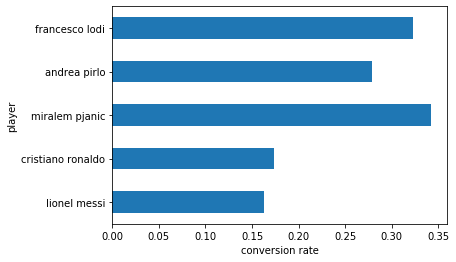

In [39]:
def free_kicks_conversion_rate(player):
    player_free_kicks=free_kicks[free_kicks['player']==player]
    scored = player_free_kicks[player_free_kicks['is_goal']]
    conversion_rate = scored.shape[0] / player_free_kicks.shape[0]
    return (player, conversion_rate)

all_players = []
for player in top_five_players.index.values.tolist():
    all_players.append(free_kicks_conversion_rate(player))

df = pd.DataFrame(all_players, columns=['player', 'conversion rate'])
df.plot(kind='barh', x='player', legend=False)
plt.xlabel('conversion rate')
plt.show()

Аlthough both plazes from Spain had scored more goals, the players from Italy have far better conversion rate and prove to be much more potent from free kicks.

### Odds Comparison
Odds are interpreted as the amount you will recieve back for every 1 USD you bet on that result. For example, if the odds for a home win is 4, you will recieve 4 USD for every 1 USD you bet on a home win. Thus, from the perspective of the bookmaker, they would set a lower odd for the result they predict. The following function would return the bookmakers' predicted result of a match based on the highest odds for each result for a particular match.

In [50]:
def odds_pred_result(odds_home, odd_draw, odd_away):
    if odds_home < odd_draw and odds_home < odd_away:
        return ('Home Win')
    elif odd_draw < odds_home and odd_draw < odd_away:
        return ('Draw')
    elif odd_away < odd_draw and odd_away < odds_home:
        return ('Away Win')

And this function will return the actual result:

In [66]:
def actual_result(home_goals, away_goals):
    if home_goals > away_goals:
        return ('Home Win')
    elif home_goals == away_goals:
        return ('Draw')
    elif home_goals < away_goals:
        return ('Away Win')

def actual_result_encode(home_goals,away_goals):
    if home_goals > away_goals:
        return (1)
    elif home_goals == away_goals:
        return (2)
    elif home_goals < away_goals:
        return (3)

We now compare the chances of us predicting the result of the game correctly just by looking at the odds. 

In [128]:
def check_prediction(data):
    correct=0
    wrong=0
    for i in range(1,data.shape[0]+1):
        odd_h = data[i-1:i]['odd_home'].item()
        odd_d = data[i-1:i]['odd_draw'].item()
        odd_a = data[i-1:i]['odd_away'].item()
        fthg = data[i-1:i]['home_goals'].item()
        ftag = data[i-1:i]['away_goals'].item()
        oddsresult=odds_pred_result(odd_h,odd_d,odd_a)
        actresult=actual_result(fthg,ftag)
        if oddsresult==actresult:
            correct+=1
        else:
            wrong+=1
    return(str('%.8f'%(correct/(correct+wrong)))+str('% correct'))

In [129]:
check_prediction(odds_data)

'0.53253560% correct'

So, if we try to predict results purely on the base of the odds, we will be right in just a little more of half of the cases.

### Another way of Predicting

We will try to use the odds and the difference among the odds to predict the result of a match.

In [69]:
x_var=odds_data.iloc[:,6:11]
x_var.head()


,home_goals,away_goals,odd_home,odd_draw,odd_away
0,3,1,1.56,4.41,7.42
1,2,2,2.36,3.60,3.40
2,2,0,1.83,4.20,4.80
3,0,1,1.55,4.50,9.40
4,1,0,2.50,3.40,3.45


In [78]:
x_var=odds_data.iloc[:,6:11]
result=[]
for i in range(1,odds_data.shape[0]+1):
    result.append(actual_result_encode(odds_data[i-1:i]["home_goals"].item(),odds_data[i-1:i]["away_goals"].item()))
y=pd.DataFrame(result)
x_var["diff_h_d"]=abs(x_var["odd_home"]-x_var["odd_draw"])
x_var["diff_d_a"]=abs(x_var["odd_draw"]-x_var["odd_away"])
x_var["diff_h_a"]=abs(x_var["odd_home"]-x_var["odd_away"])
x_var=x_var.drop(["home_goals","away_goals"],axis=1)
x_var.head()

,odd_home,odd_draw,odd_away,diff_h_d,diff_d_a,diff_h_a
0,1.56,4.41,7.42,2.85,3.01,5.86
1,2.36,3.60,3.40,1.24,0.20,1.04
2,1.83,4.20,4.80,2.37,0.60,2.97
3,1.55,4.50,9.40,2.95,4.90,7.85
4,2.50,3.40,3.45,0.90,0.05,0.95


We will visualise the results of out predictions using confusion matrix. It will show how many of our guesses were right and how many were wrong.

In [110]:
def confusion_matrix_model(model_used):
    cm=confusion_matrix(y_train,model_used.predict(x_train))
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Home Win","Predicted Draw","Predicted Away Win"]
    cm.index=["Actual Home Win","Actual Draw","Actual Away Win"]
    return cm

In [111]:
x_train,x_test,y_train,y_test=train_test_split(x_var,y,test_size=0.2,random_state=0)

#### Logistic Regression

In [112]:
log_reg=LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000)
log_reg.fit(x_train,y_train.values.ravel())
print("Logistic Regression Cross Validation Accuracy: {}".format(accuracy_score(y_train, log_reg.predict(x_train))))
confusion_matrix_model(log_reg)

Logistic Regression Cross Validation Accuracy: 0.5276301149709482


,Predicted Home Win,Predicted Draw,Predicted Away Win
Actual Home Win,3235,3,486
Actual Draw,1547,0,507
Actual Away Win,1278,0,1033


The logistic regression did not gave us much better percentage as compared to the odds. It is true, that our dataset is not so big, so if we add cross validation, maybe the accuracy would improve. We will use K-Fold cross validation with 10 bins.

In [122]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
def cross_validate_score(model):
    return np.mean(cross_val_score(model,x_train,y_train.values.ravel(),cv=k_fold,scoring="accuracy"))
print("Logistic Regression Cross Validation Accuracy: {}".format(cross_validate_score(log_reg)))

Logistic Regression Cross Validation Accuracy: 0.5263942772521999


Giving that the cross-calidation has made tests on all of our data the accuracy metrics of the second try should be more close to the truth and we can see, that the regression model is even more error prone.

#### Decision Tree Regression
Decision tree builds regression or classification models in the form of a tree structure. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes. As suggested by Tim Bock in the article [Decision Trees Are Usually Better Than Logistic Regression](https://www.displayr.com/decision-trees-are-usually-better-than-logistic-regression/Decision) the decision trees, although more memory expensive, are with better chance of prediction, compared to the Logistic regression. Lets see if this will confirm with out dataset.

In [127]:
decision_tree=DecisionTreeClassifier()
decision_tree.fit(x_train,y_train)
print('Decision Tree Regression Accuracy (without cross validation): {}'.format(accuracy_score(y_train, decision_tree.predict(x_train))))
print('Decision Tree Regression Cross Validation Accuracy: {}'.format(cross_validate_score(decision_tree)))
confusion_matrix_model(decision_tree)

Decision Tree Regression Accuracy (without cross validation): 0.9749041908764989
Decision Tree Regression Cross Validation Accuracy: 0.4278665752854643


,Predicted Home Win,Predicted Draw,Predicted Away Win
Actual Home Win,3722,2,0
Actual Draw,89,1965,0
Actual Away Win,63,49,2199


For our dataset wuthout cross validation the score is really hugh, but when we put it on cross validation the average value from the ten validations is much lower and shows us in out case the tree might even be much more error prone.

#### Support Vector Machine
The objective of the support vector machine algorithm is to find the hyperplane that has the maximum margin in an N-dimensional space(N — the number of features) that distinctly classifies the data points. It is 

In [134]:
svm_reg=svm.SVC(gamma = 'auto')
svm_reg.fit(x_train,y_train.values.ravel())
print('SVM Regression Accuracy (without cross validation):{}'.format(accuracy_score(y_train, svm_reg.predict(x_train))))
print('SVM Regression Cross Validation Accuracy: {}'.format(cross_validate_score(svm_reg)))
confusion_matrix_model(svm_reg)

SVM Regression Accuracy (without cross validation):0.5317097292619607
SVM Regression Cross Validation Accuracy: 0.5275055379456364


,Predicted Home Win,Predicted Draw,Predicted Away Win
Actual Home Win,3204,0,520
Actual Draw,1501,7,546
Actual Away Win,1221,0,1090


Still the predictions are worse than those made by the odds, so still there is no better way of predicting the games.